# Modelo de Pairs Trading Baseado em Cointegração

**Autores: Alexandre Fernandes Theoharidis, Débora Darin e Nelly Pires Colnaghi**

## Introdução

O trabalho foi inspirado no artigo do Caldeira (2013), que implementou um modelo de pairs trading baseado em cointegração no mercado brasileiro de ações. Nele é feita uma construção de spreads com reversão à média com a finalidade de explorar os desvios que ocorrem ao longo do tempo. O cálculo dos spreads entre as ações do par foi realizado utilizando tanto o método de OLS como o filtro de Kalman para fins de comparação de performance. A estratégia implementada baseou-se em modelo com thresholds e no kNN para identificação dos pontos de abertura e fechamento do trade, a ser detalhada mais adiante.

Os dados utilizados no projeto compreendem as séries históricas de preços das ações ordinárias e preferenciais da Petrobras (PETR3 e PETR4, respectivamente). Foram coletados preços diários de janeiro de 2008 a março de 2020. A escolha dessas ações se justifica pelo fato de que são papéis emitidos pela mesma empresa e, portanto, deveriam apresentar cointegração. 

O trabalho está organizado da seguinte forma:

1) Importação de base e tratamento de dados;

2) Funções para cálculo do spread pelos métodos OLS e filtro de Kalman;

3) Funções para backtests com thresholds predeterminados e com kNN, usando ambos os métodos de estimação do spread (OLS e filtro de Kalman);

4) Implementação da estratégia usando o par PETR3 x PETR4.

## Bibliotecas

Abaixo estão todas as bibliotecas utilizadas no código.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pykalman import KalmanFilter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações

As configurações necessárias às bibliotecas empregadas no modelo estão consolidadas abaixo.

In [2]:
# Comando para que os gráficos sejam exibidos no corpo do texto
%matplotlib inline 

In [3]:
plt.rcParams['figure.dpi'] = 200 # Resolução dos gráficos impressos no pdf (dpi)

In [5]:
# Estilo dos gráficos
sns.set(color_codes = True)

## Parâmetros

Esses são os parâmetros referentes aos modelos de pairs trading que são implementados no código, a serem detalhados mais a frente.

In [6]:
alfa = 0.01 # Nível de significância utilizado nos testes de hipótese 
janela_dados = 126 # tamanho da janela de dados utilizada para estimação dos modelos
janela_desloc = 30 # número de períodos de deslocamento da janela móvel a cada iteração no cálculo do spread pelo OLS
janela_update = 60 # número de dias da janela de atualização dos coeficientes e do spread no método OLS
janela_coint = 5 # janela de dias que será analisada para determinação da cointegração das ações de um par
cost = 0.0005 # custo de execução 
th_OLS = 2 # Número de desvios-padrão de distância da média para abertura de posição 

## Importação e Tratamento dos Dados

In [12]:
# Leitura da planilha com as séries de preços diários das ações de cada par

str_dir = 'D:/Estudos/2 Mestrado/Insper/Disciplinas/Finanças Quantitativas/Projeto/'
str_plan_bd_stocks = 'BD_Stocks_v3'

df_prices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_bd_stocks + '.csv', sep=';')
df_prices.index = df_prices['Dates']
df_prices.index = pd.to_datetime(df_prices['Dates'])
df_prices = df_prices.drop(columns=['Dates'])
df_prices = df_prices.dropna()

In [13]:
# Log preços - serão usados nos testes de cointegração
df_log_prices = np.log(df_prices)
df_log_prices.head()

,PETR3 BZ Equity,PETR4 BZ Equity
Dates,,
2008-01-01,3.960813,3.788725
2008-02-01,3.954220,3.772761
2008-03-01,3.939638,3.756538
2008-04-01,3.878466,3.706228
2008-07-01,3.843530,3.676427


## Cálculo dos Spreads

Nessa sessão realizamos o cálculo do spread dos pares de ações de duas formas: uma utilizando o método OLS e outra utilizando o filtro de Kalman. A função do spread será utilizada mais a frente na função de backtest para a estratégia do pair trading. Posteriormente, os dois métodos serão comparados entre si de acordo com o resultado obtido na estratégia.

### Regressão Usando Filtro de Kalman

A função abaixo implementa a regressão do log preço de uma ação contra o log preço da outra ação do par utilizando o filtro de Kalman. Ela retorna os coeficientes estimados ao longo do tempo, o resíduo (spread), as matrizes de covariância dos coeficientes e um objeto contendo o filtro de Kalman ajustado.

Essa função é empregada na função spread_KF para computar o spread de cada par de ações da base.

In [17]:
'''Parâmetros da função:
-> y, x : log preços do par de ações.
-> delta: parâmetro relacionado à variância. Quanto mais próximo de 1, mais voláteis são os betas, melhor o ajuste
porém pior a capacidade preditiva do filtro. Quanto mais próximo de zero, mais estáveis são os betas, porém a capacidade 
preditiva é ruim. Há então um ponto ótimo no meio desse intervalo. 
-> obs_cov: matriz de covariância das observações - variáveis de estado.
-> init_mean, init_cov: são os valores iniciais da média e da matriz de covariância dos betas para inicialização do filtro.
-> intercept: se você deseja rodar regressão com (TRUE) ou sem (FALSE) intercepto.
-> em: se você deseja utilizar o algoritmo "em" para estimar os valores iniciais da média e da matriz de covariância dos betas.
''' 

def KFReg(y, x, delta, obs_cov, init_mean, init_cov, intercept = False, em = False):
    if intercept == True: #caso regressão utilize intercepto
        obs_mat = np.vstack([x, np.ones(x.shape)]).T[:, np.newaxis] 
        if em == False:
            trans_cov = delta / (1 - delta) * np.eye(2)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = np.eye(2), # Essa é a matriz que define o random walk
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.filter(y.values)
        beta0 = state_means[:,1]
        beta1 = state_means[:,0]
        resid = y - beta0 - beta1*x
        return beta0, beta1, resid, state_covs, kf
    else:
        obs_mat = np.vstack([x]).T[:, np.newaxis]
        if em == False:
            trans_cov = delta / (1 - delta)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 1, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = 1,
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 1, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.em(y.values).filter(y.values)
        beta1 = state_means[:,0]
        resid = y - beta1*x
        return beta1, resid, state_covs, kf

### Cálculo do Spread de um Par de Ações Usando OLS

In [18]:
# Função para cálculo do spread
# A variável 'janela_dados' define o tamanho da janela móvel
# A variável 'janela_desloc' define o número de períodos de deslocamento da janela móvel a cada iteração
# Convenção: log_price1 é regredido contra log_price2
# A função retorna, para cada janela móvel:
    # O spread
    # O resultado do teste ADF para verificação da estacionariedade (1 = estacionário)
    # Os coeficientes da regressão: beta0 = intercepto, beta1 = beta do log_price1 contra log_price2

def spread_OLS(log_price1, log_price2, janela_dados, janela_desloc):   
    
    y = log_price1
    x = log_price2
    x = sm.add_constant(x)
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1 # Número de janelas
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['ADF'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    
    while fim <= T:
        
        results = sm.OLS(y.iloc[np.arange(inicio,fim)], x.iloc[np.arange(inicio,fim)]).fit()
        beta0.iloc[i,0] = results.params[0]
        beta1.iloc[i,0] = results.params[1]
        s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(results.resid).values
        
        adf_res.iloc[i,0] = 1*(adfuller(x = s.iloc[np.arange(inicio,fim),:], regression = 'c', autolag = 'BIC')[1] < alfa)


        inicio = inicio + janela_desloc
        fim = fim + janela_desloc
        i = i + 1
    
    s = s.dropna()
    
    return s, adf_res, beta0, beta1

### Cálculo do Spread Usando Filtro de Kalman

In [19]:
# Os parâmetros são os mesmos utilizados na função da regressão do filtro de Kalman, com exceção de:
# janela_dados: define o tamanho da janela móvel

def spread_KF(log_price1, log_price2, janela_dados, delta, obs_cov, init_mean0, init_cov, intercept = False, em = False):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['ADF'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    init_mean = init_mean0
    
    while fim <= T:
        
        x_array = x.iloc[np.arange(inicio,fim)]
        y_array = y.iloc[np.arange(inicio,fim)]
        res = KFReg(y = y_array, x = x_array, 
                    delta = delta, obs_cov = obs_cov, 
                    init_mean = init_mean, init_cov = init_cov, 
                    intercept = intercept, em = em)
        if intercept == False:
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[1], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        else:
            beta0.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[2]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[2], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        
        inicio = inicio + 1
        if intercept == False:
            init_mean = beta1.iloc[inicio,0]
        else:
            init_mean = np.array([beta1.iloc[inicio,0],
                                    beta0.iloc[inicio,0]])
        fim = fim + 1
        i = i + 1
    
    s = s.dropna()
    
    if intercept == False:
        return s, adf_res, beta1
    else:
        return s, adf_res, beta0, beta1

## Backtest

O objetivo dessa seção é efetuar um backtest da estratégia de pairs trading para verificação de seu retorno no período analisado. Para realização do backtest da estratégia, utilizaremos as seguintes combinações de modelos, implementados individualmente em funções:

1) Thresholds com método de estimação OLS (backtest_OLS);

2) kNN com método de estimação OLS (backtest_OLS_kNN);

3) Thresholds com método de estimação via Filtro de Kalman (backtest_KF); e

4) kNN com método de estimação via Filtro de Kalman (backtest_KF_kNN).

A figura abaixo ilustra a estratégia de pairs trading com thresholds. Mostra que as posições são abertas quando o spread se situa nas regiões inferior ou superior de fora da banda delimitada pelos threholds, definidos com um múltiplo do desvio-padrão do spread. Ademais, as posições são fechadas quando o spread cruza o eixo 0. 

Quando o método kNN é utilizado, o critério para abertura e fechamento de posições se torna a própria classificação produzida pelo kNN, que indica se será lucrativo ou não negociar o par em cada dia. Quando a indicação é positiva, o par é aberto, e, quando não for, as posições são fechadas.

Em relação aos métodos empregados para estimar o spread, quando é adotado o OLS, a função implementada executa o OLS em janelas móveis, havendo uma janela móvel de dados que são usados para estimação dos parâmetros do OLS, atualizados a cada iteração, e outra janela adjacente na qual o par é negociado de acordo com o nível do spread. A cada iteração da função de backtest, as janelas de dados e de trade são deslocadas um número de dias fixo. No caso do filtro de Kalman, este permite estimação diária dos coeficientes da regressão. 

Quando um par é aberto, o tamanho da posição não sofre ajuste até que haja convergência do spread para  a média, mesmo que o spread continue se desviando da média, tornando a estratégia teoricamente mais atratativa. O único ajuste implementado é um ajuste decorrente da variação do beta ao longo do tempo, que determina a proporção relativa das ações do par que devem ser compradas.

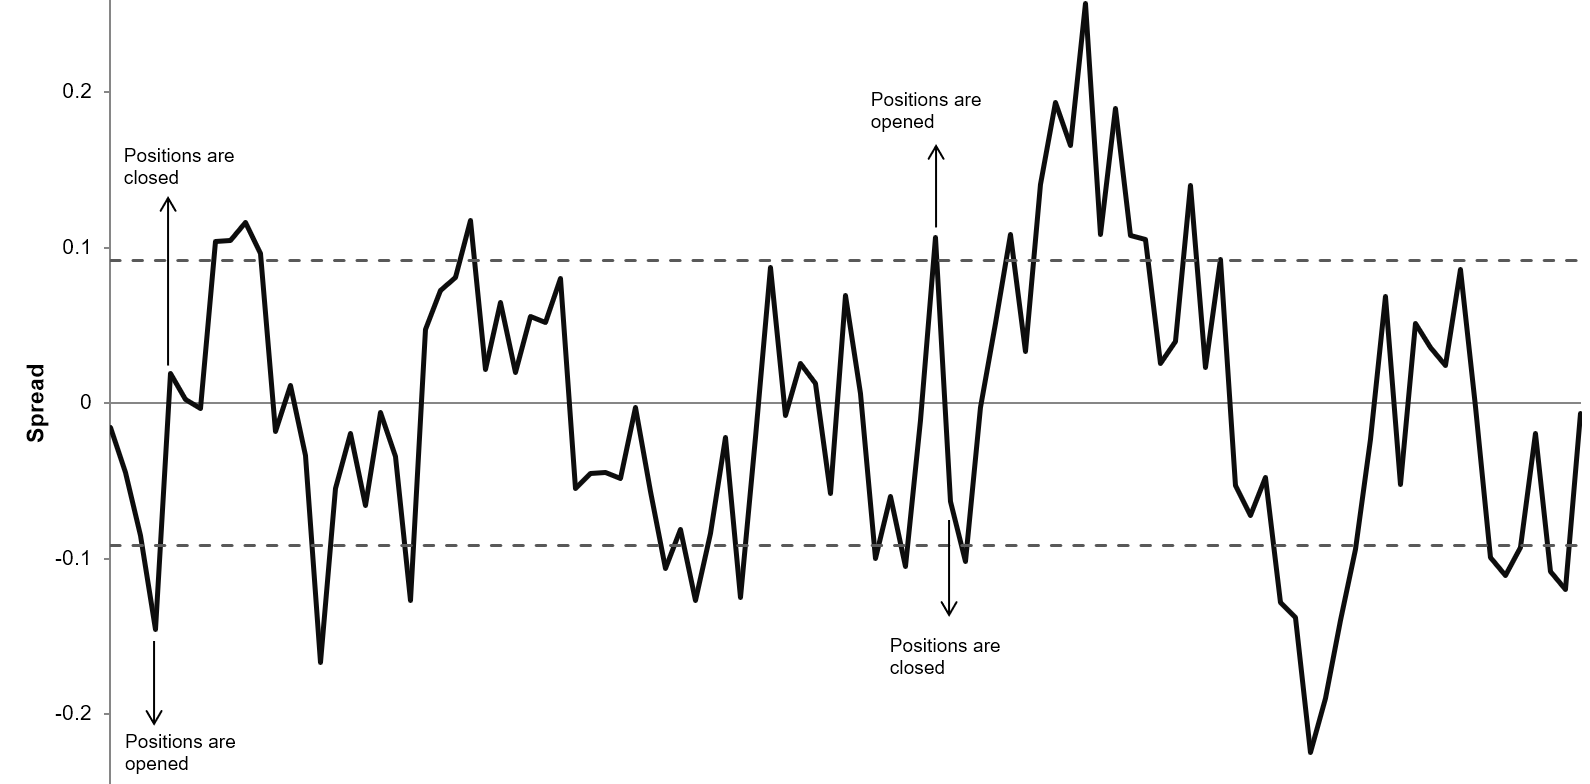

In [35]:
myImage = Image.open(str_dir + 'Figura_Pairs_Trading.png')
myImage

### Função para Realização do Backtest da Estratégia Usando OLS e Thresholds

In [64]:
# Função para implementação da estratégia e do backtest
# Essa função replica a estratégia de pairs trading com custos de transação
# Os custos são aplicados somente na realização do trade, para fins de simplificação

def backtest_OLS(log_price1, log_price2, df_spread, df_beta1, df_coint_res,
                 janela_dados, janela_desloc, janela_update, cost, th):
    
    y = log_price1
    x = log_price2
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1 # número de janelas
    
    # janela_trade: janela na qual o par é negociado, delimitada por inicio_trade e fim_trade
    # janela_est: janela cujos dados servem para estimar os parâmetros, delimitada por
    # inicio_est e fim_est
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    inicio_trade = fim_est 
    fim_trade = fim_est + janela_desloc
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # +1 se o par foi aberto quando o spread estava na região superior de fora
    pos_aberto = -1 
    
    i = 0
    k = 0
    
    while fim_trade <= T:
        
        if df_coint_res.iloc[i,0] == True:
            
            j = 0
            
            for k in np.arange(inicio_trade, fim_trade):
                    
                inicio_update = fim_est + j - janela_update
                fim_update = fim_est + j
                
                reg = sm.OLS(y.iloc[np.arange(inicio_update, fim_update)], 
                                     sm.add_constant(x.iloc[np.arange(inicio_update, fim_update)])).fit()
                beta0 = reg.params[0]
                beta1 = reg.params[1]
                avg_spread = np.mean(reg.resid)
                vol_spread = np.std(reg.resid, ddof = 1)
                spread_trade = reg.resid[-1]
                
                lim_sup = avg_spread + th*vol_spread
                lim_inf = avg_spread - th*vol_spread
                
                # Caso 1: spread na parte superior de fora da banda
                if spread_trade > lim_sup:
                    
                    # Caso 1.1: sem posição em aberto --> abre posição
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = 1
                    
                    # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                j = j + 1
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[k+1,0] = -(y.iloc[k+1]-y.iloc[k]) + beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[k+1,0] = (y.iloc[k+1]-y.iloc[k]) - beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + janela_desloc
        fim_est = fim_est + janela_desloc
        inicio_trade = fim_est 
        fim_trade = fim_est + janela_desloc
        i = i + 1
        
    return df_log_retornos

### Funções para Implementação do kNN

Para implementação do kNN, foram elaboradas funções auxiliares com os seguintes objetivos:

1) Retornos_Pares: função que calcula o retorno da estratégia de pairs trading para todos os dias nos quais há cointegração, independentemente do valor do spread. O nível do spread não é considerado na decisão de negociar o par porque, posteriormente, será o kNN que fornecerá essa informação na função de backtest;

2) knn_par: função que ajusta o kNN aos dados (spread), posteriormente chamada dentro da função de backtest para determinar em quais dias deve haver trade ou não. Também retorna a matriz de confusão do modelo.

In [42]:
# Função auxiliar para gerar os retornos diários da estratégia de pairs trading
# É usada pela função de kNN para classificação dos dias da amostra
# Determina qual o retorno da estratégia quando aberta em um dia qualquer do período

def retornos_pares(df_spread, df_coint_res, janela_coint):

    T = df_coint_res.shape[0]
    
    df_retornos = pd.DataFrame(np.nan, index = df_spread.index, columns = ['Retorno'])
    
    for i in np.arange(janela_coint,T-1):
        
        # df_coint_res retorna se o par está cointegrado (=1) ou não (=0)
        # o critério para concluir que há cointegração é ajustado
        # olhando df_coint_res ao longo de uma janela de tamanho janela_coint =
        # = i - (i - janelas_coint) = janela_coint
        # se em todos os dias da janela houver cointegração, então, por convenção
        # concluímos que há cointegração na janela
        if np.min(df_coint_res.iloc[np.arange(i-janela_coint, i), 0]) == True:
            
            # If-else para determinar se a posição é aberta na região superior ou inferior
            # à média do spread
            if df_spread.iloc[i,0] > 0:
                pos_aberto = 1
            else:
                pos_aberto = -1
            
            retorno = 0
            
            for j in np.arange(i+1,T):
                
                if pos_aberto == 1:
                    retorno = retorno + df_spread.iloc[j-1,0] - df_spread.iloc[j,0]
                else:
                    retorno = retorno + df_spread.iloc[j,0] - df_spread.iloc[j-1,0]
                
                if df_spread.iloc[i,0] > 0:
                    
                    if df_spread.iloc[j,0] <= 0:
                        
                        break
                        
                if df_spread.iloc[i,0] < 0:
                    
                    if df_spread.iloc[j,0] >= 0:
                        
                        break
                        
                if np.min(df_coint_res.iloc[np.arange(j-janela_coint, j), 0]) == False:
                    
                    break
                        
            h = j - i
            
            df_retornos.iloc[i,0] = retorno/h
    
    df_retornos = df_retornos.dropna()
    
    return df_retornos

In [86]:
# passar o cdi para trocar o critério
# EM CONSTRUÇÃO - no momento estamos utilizado a mediana como critério

def knn_par(df_spread, df_coint_res, janela_desloc, janela_coint, k, method):
    
    if method == 'OLS':
        df_coint_res = pd.DataFrame(np.repeat(df_coint_res.values, janela_desloc))
    s_norm = (df_spread - np.mean(df_spread))/np.std(df_spread, ddof=1)
    r = retornos_pares(s_norm, df_coint_res, janela_coint)
    r = 1*(r>=np.median(r))
    yX = pd.concat([r,np.abs(s_norm).shift(-1)],axis=1,sort=True).dropna()
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh_fit = neigh.fit(yX.iloc[:,1:].values.reshape(-1,1), yX.iloc[:,0])
    
    obs_values = r
    fitted_values = neigh_fit.predict(yX.iloc[:,1:])
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true = obs_values, y_pred = fitted_values), 
                                   index = ['Negative', 'Positive'], 
                                   columns = ['Negative', 'Positive'])
    
    return neigh_fit, fitted_values, df_confusion_matrix

 ### Função para Realização do Backtest Usando OLS e kNN

In [ ]:
# Função não está pronta - EM CONSTRUÇÃO

def backtest_OLS_kNN(log_price1, log_price2, df_spread, df_beta1, df_coint_res,
                 janela_dados, janela_desloc, janela_update, cost, th):
    
    y = log_price1
    x = log_price2
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    inicio_trade = fim_est 
    fim_trade = fim_est + janela_desloc
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # +1 se o par foi aberto quando o spread estava na região superior de fora
    pos_aberto = -1 
    
    i = 0
    k = 0
    
    while fim_trade <= T:
        
        if df_coint_res.iloc[i,0] == True:
            
            j = 0
            
            for k in np.arange(inicio_trade, fim_trade):
                    
                inicio_update = fim_est + j - janela_update
                fim_update = fim_est + j
                
                reg = sm.OLS(y.iloc[np.arange(inicio_update, fim_update)], 
                                     sm.add_constant(x.iloc[np.arange(inicio_update, fim_update)])).fit()
                beta0 = reg.params[0]
                beta1 = reg.params[1]
                avg_spread = np.mean(reg.resid)
                vol_spread = np.std(reg.resid, ddof = 1)
                spread_trade = reg.resid[-1]
                
                lim_sup = avg_spread + th*vol_spread
                lim_inf = avg_spread - th*vol_spread
                
                # Caso 1: spread na parte superior de fora da banda
                if spread_trade > lim_sup:
                    
                    # Caso 1.1: sem posição em aberto --> abre posição
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = 1
                    
                    # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                j = j + 1
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[k+1,0] = -(y.iloc[k+1]-y.iloc[k]) + beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[k+1,0] = (y.iloc[k+1]-y.iloc[k]) - beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + janela_desloc
        fim_est = fim_est + janela_desloc
        inicio_trade = fim_est 
        fim_trade = fim_est + janela_desloc
        i = i + 1
        
    return df_log_retornos
    

In [116]:
'''
Essa função realiza o backtest da estratégia usando o filtro de Kalman e threshold predeterminados
'''

def backtest_KF(log_price1, log_price2, df_spread, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, th, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    '''
    -1 se o par foi aberto quando o spread estava na região inferior de fora
    +1 se o par foi aberto quando o spread estava na região superior de fora
    '''
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-1,0]
    beta1 = df_beta1.iloc[fim_est-1,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1) - (fim_est - janela_coint) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint, fim_est), 0]) == True:
            
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-1,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-1,0]
            
            avg_spread = np.mean(s.iloc[np.arange(inicio_est, fim_est)]).values
            vol_spread = np.std(s.iloc[np.arange(inicio_est, fim_est)], ddof = 1).values
            spread_trade = df_spread.iloc[fim_est-1].values
                        
            lim_sup = avg_spread + th*vol_spread
            lim_inf = avg_spread - th*vol_spread
                
            # Caso 1: spread na parte superior de fora da banda
            if spread_trade > lim_sup:
                    
                # Caso 1.1: sem posição em aberto --> abre posição
                if par_aberto == False:
                    
                    beta1 = df_beta1.iloc[fim_est-1,0]
                    par_aberto = True
                    pos_aberto = 1
                    
                # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                    
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                    
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        beta1 = df_beta1.iloc[fim_est-1,0]
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2 
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

In [117]:
'''
Essa função realiza o backtest da estratégia usando filtro de Kalman e knn para determinação dos
dias nos quais há trade.
'''

def backtest_KF_knn(knn_fit, log_price1, log_price2, df_spread, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    '''
    -1 se o par foi aberto quando o spread estava na região inferior de fora
    +1 se o par foi aberto quando o spread estava na região superior de fora
    '''
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-1,0]
    beta1 = df_beta1.iloc[fim_est-1,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1) - (fim_est - janela_coint) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint, fim_est), 0]) == True:
            
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-1,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-1,0]
            
            spread_trade = df_spread.iloc[fim_est-1].values
            
            if par_aberto == False:
                
                knn_predict = knn_fit.predict(spread_trade.reshape(-1, 1))
                
                if knn_predict == 1:
                    if spread_trade > 0:
                        pos_aberto = 1
                    else:
                        pos_aberto = -1
                    par_aberto = True
                
            else:
                
                cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                
                if pos_aberto == 1:
                    
                    if spread_trade <= 0:
                        par_aberto = False
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta - cost
                    else:
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                        
                if pos_aberto == -1:
                    
                    if spread_trade >= 0:
                        par_aberto = False
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta - cost
                    else:
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                                    
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração

        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
        
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

## Exemplo de Pair Trading - PETR3 x PETR4

Nessa sessão realizamos um exemplo de cálculo do spread das ações do par para ambos os métodos, assim como sua análise de cointegração para cada um deles. Também computamos o beta do par, que corresponde à razão entre ações do par, e plotamos as FACs dos spreads para ilustrar a estacionariedade dos mesmos.

In [47]:
# Cálculo do retorno acumulado para as séries de preço
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0 #Para casos de não intercepto na regressão do filtro de Kalman, as séries de preço são normalizadas começando em zero
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0 #Para casos de não intercepto na regressão do filtro de Kalman, as séries de preço são normalizadas começando em zero
y = y.cumsum()

In [48]:
# Cálculo do spread usando OLS
res_OLS = spread_OLS(y, x, janela_dados, janela_desloc)

In [49]:
# Variáveis que guardam os resultados do cálculo do spread usando OLS
s_OLS = res_OLS[0]
adf_OLS = res_OLS[1]
beta_OLS = res_OLS[3]

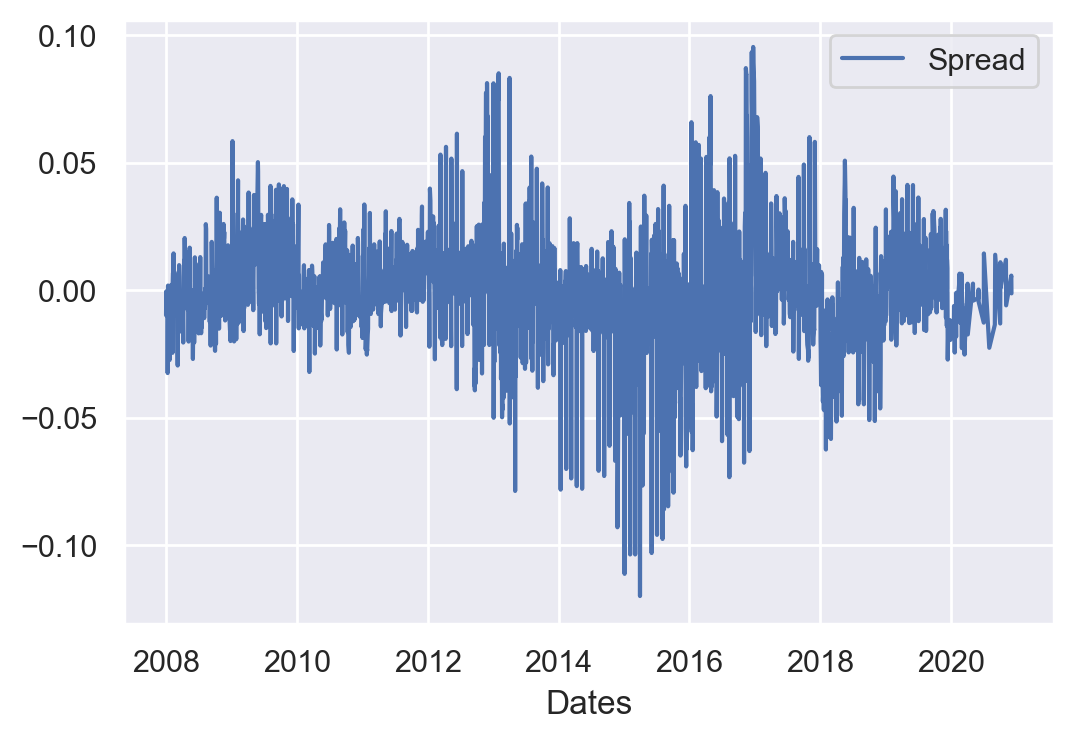

In [50]:
sns.lineplot(data = s_OLS)

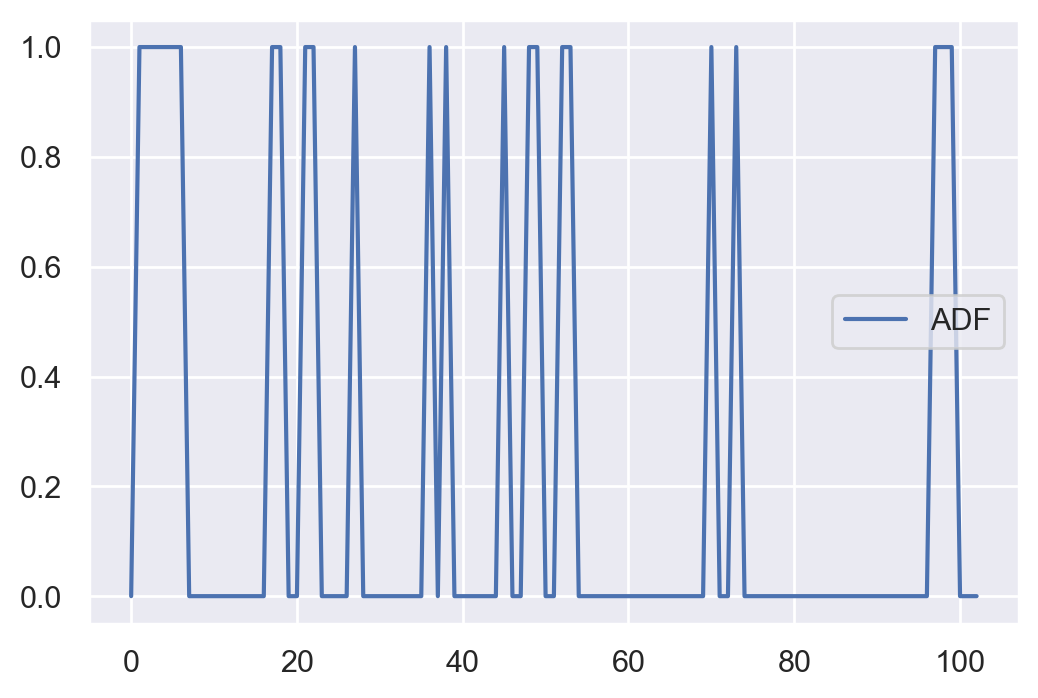

In [51]:
# Teste ADF para Spread OLS
sns.lineplot(data = adf_OLS)

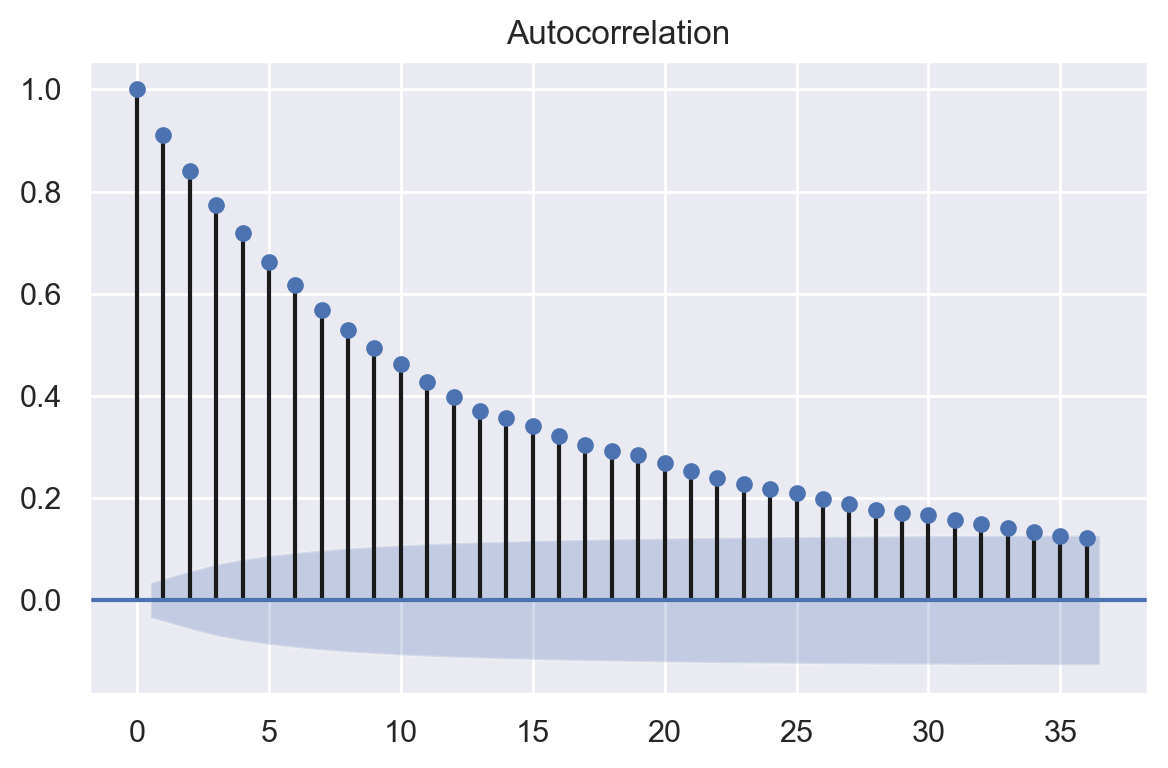

In [52]:
plot_acf(s_OLS)
plt.tight_layout()

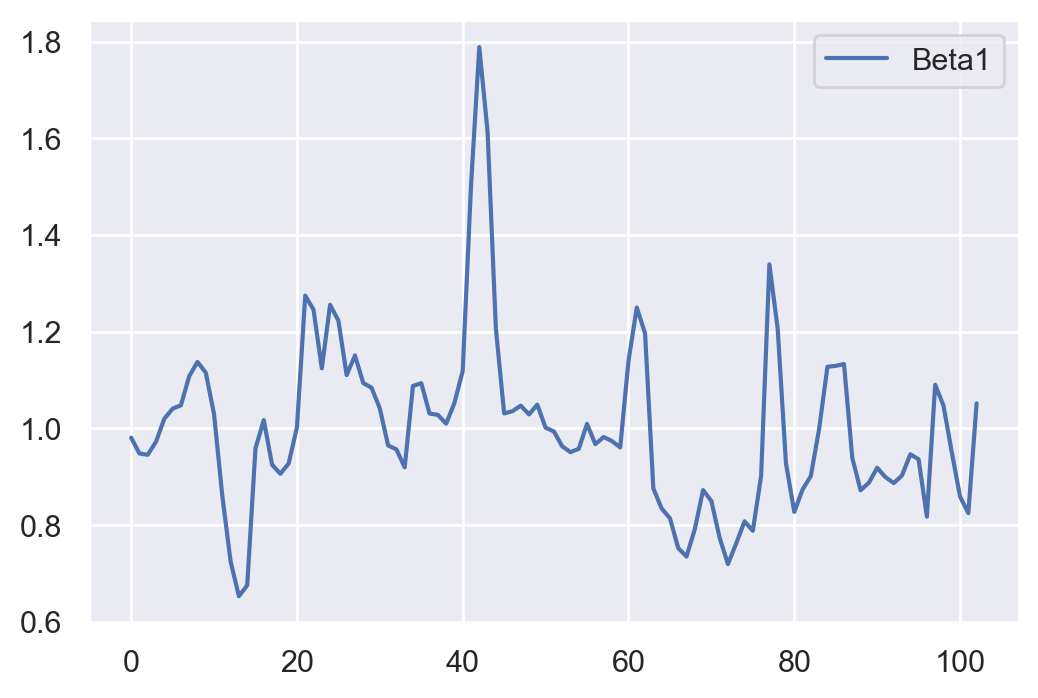

In [55]:
sns.lineplot(data = beta_OLS)

In [56]:
# Cálculo do spread usando KF com intercepto
# Valores calibrados empiricamente
res_KF = spread_KF(y, x, janela_dados, 
                delta = 1e-2, obs_cov = 0.25, 
                init_mean0 = np.array([1,0]), init_cov = np.matrix([[0.25,0],[0,0.25]]), 
                intercept = True, em = False)

In [57]:
# Variáveis que guardam os resultados do cálculo do spread usando KF
s_KF = res_KF[0]
adf_KF = res_KF[1]
beta_KF = res_KF[3]

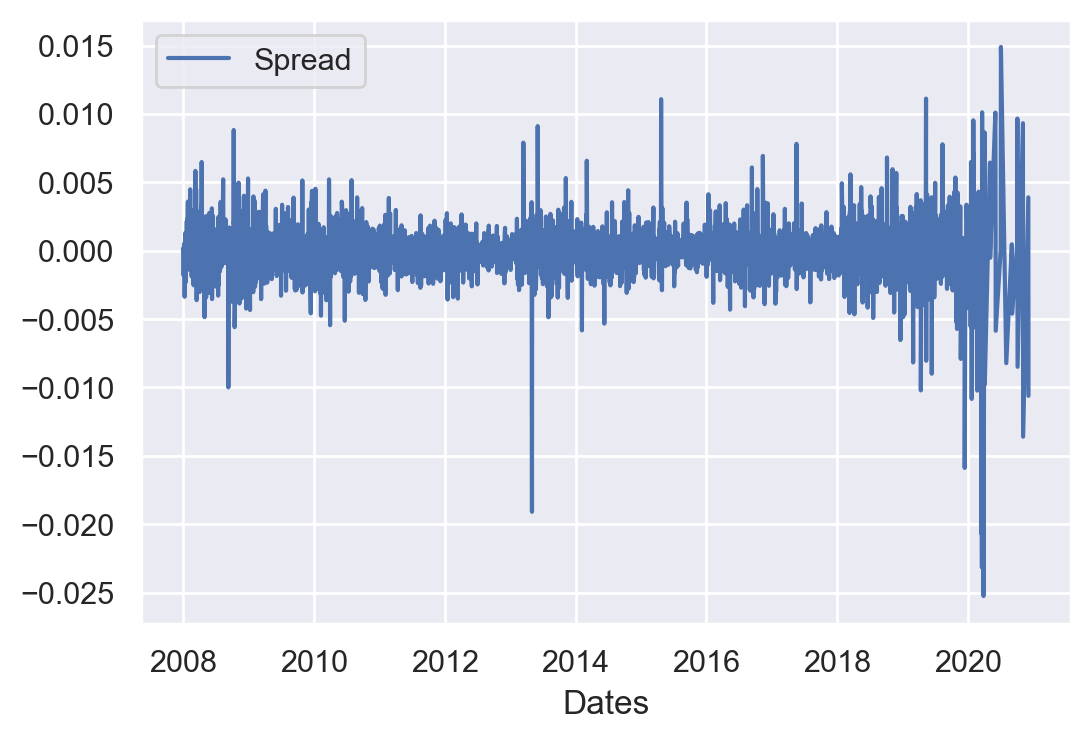

In [58]:
sns.lineplot(data = s_KF)

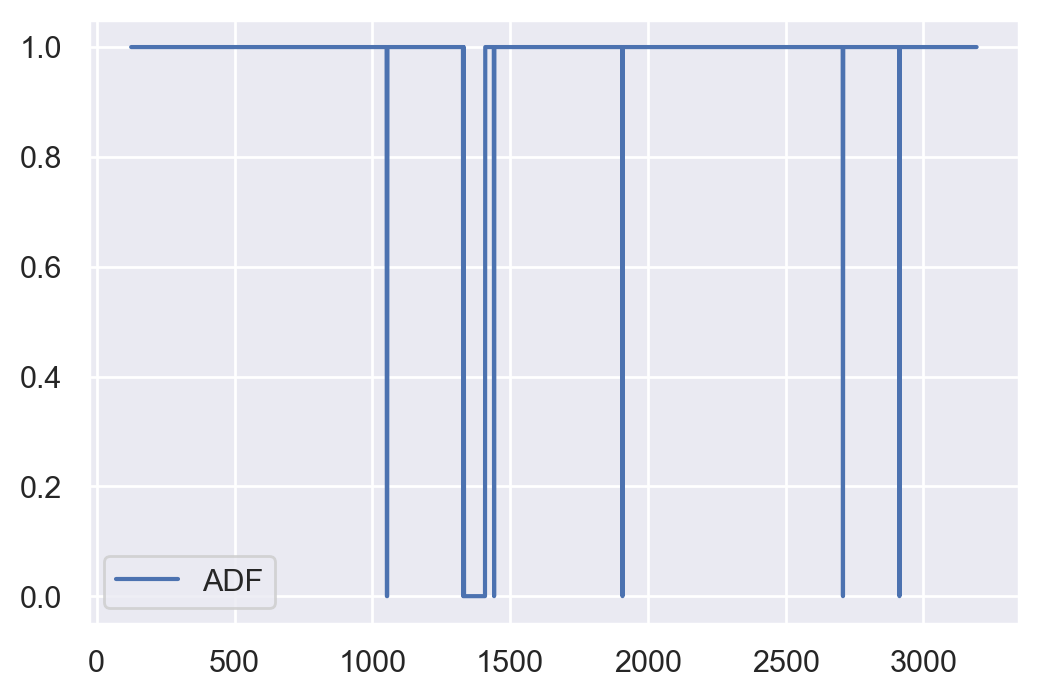

In [59]:
sns.lineplot(data = adf_KF)

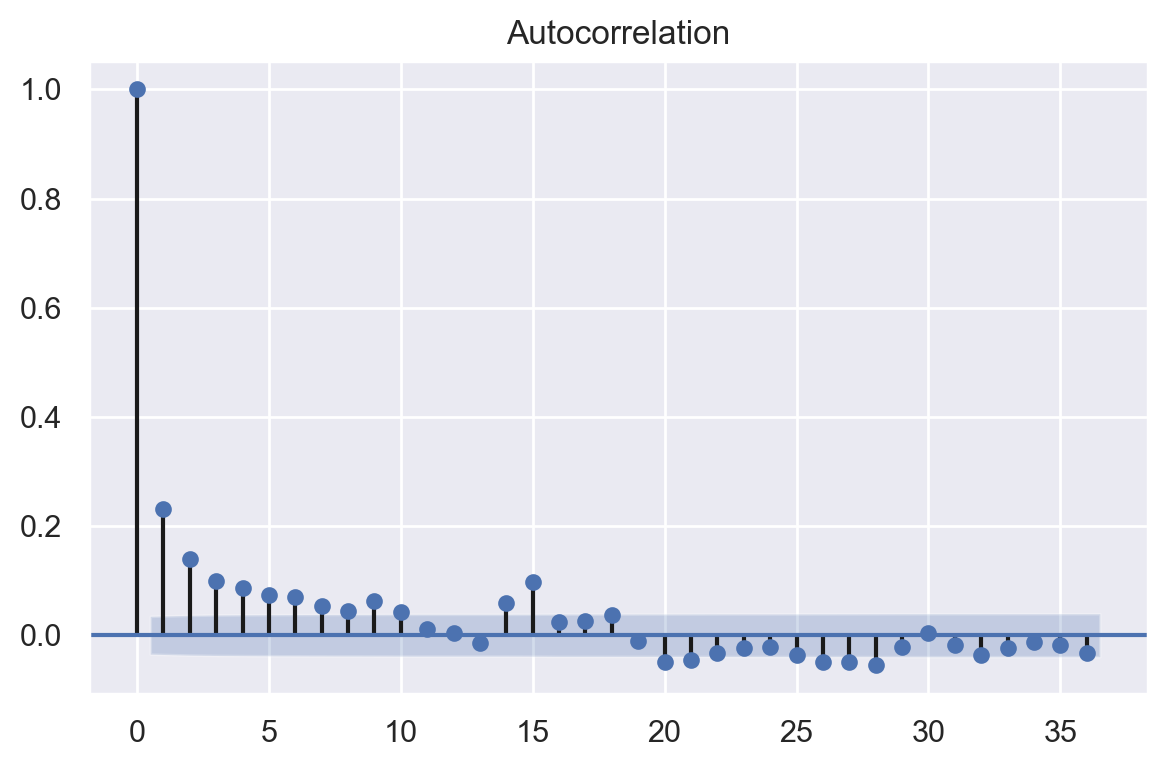

In [60]:
plot_acf(s_KF)
plt.tight_layout()

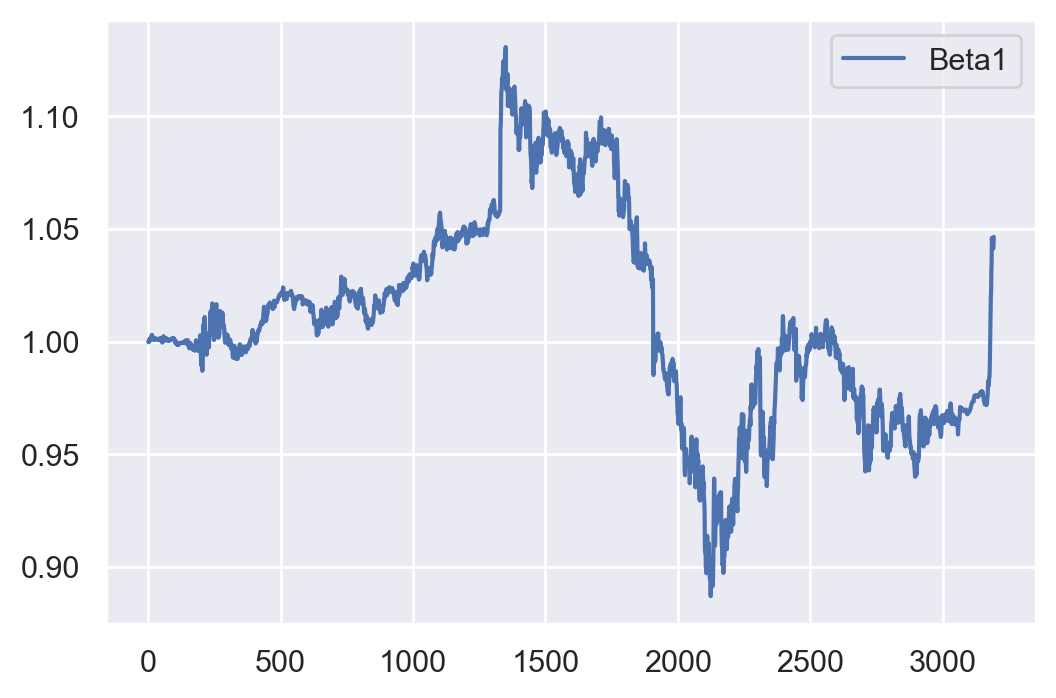

In [62]:
sns.lineplot(data = beta_KF)

In [65]:
df_log_retornos_OLS_th = backtest_OLS(y, x, s_OLS, beta_OLS, adf_OLS, janela_dados, janela_desloc, 
                                      janela_update, cost, th_OLS)

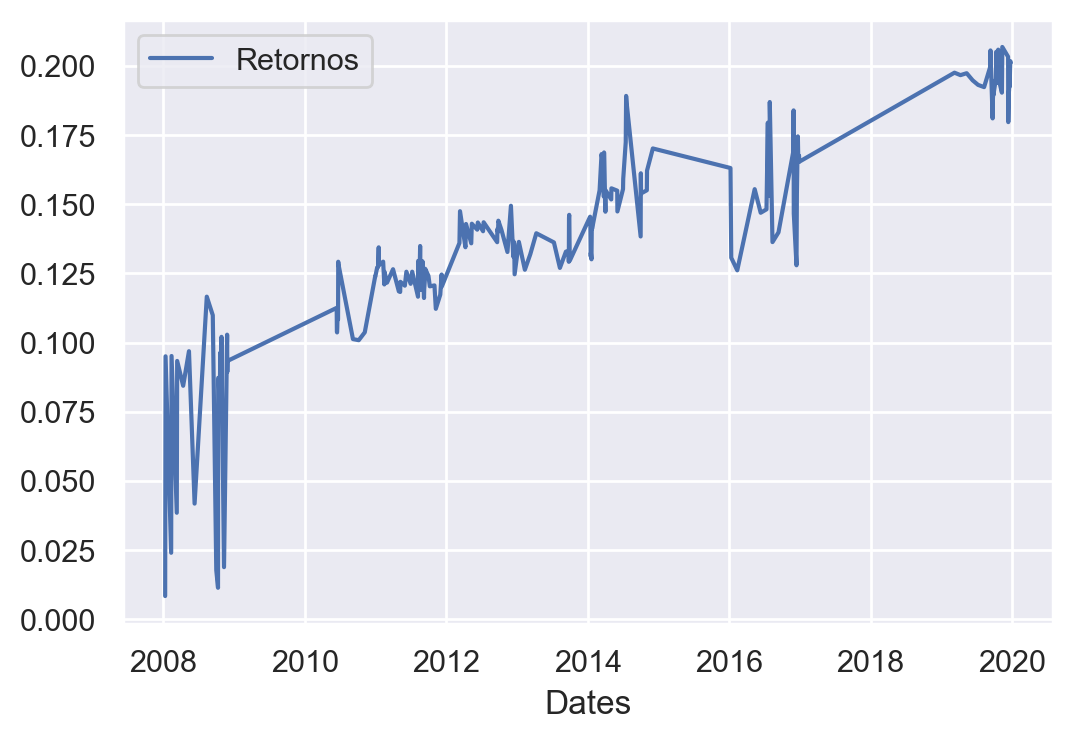

In [110]:
sns.lineplot(data=np.exp(df_log_retornos_OLS_th.cumsum())-1)

In [113]:
# Backtest da estratégia usando o kNN e o filtro de Kalman
knn_KF = knn_par(s_KF, adf_KF, janela_desloc, janela_coint, 5, 'KF')
s_KF_norm = (s_KF - np.mean(s_KF))/np.std(s_KF, ddof=1)
ret = backtest_KF_knn(knn_KF[0], y, x, s_KF_norm, beta_KF, adf_KF, 
                janela_dados, janela_coint, 0, 0)

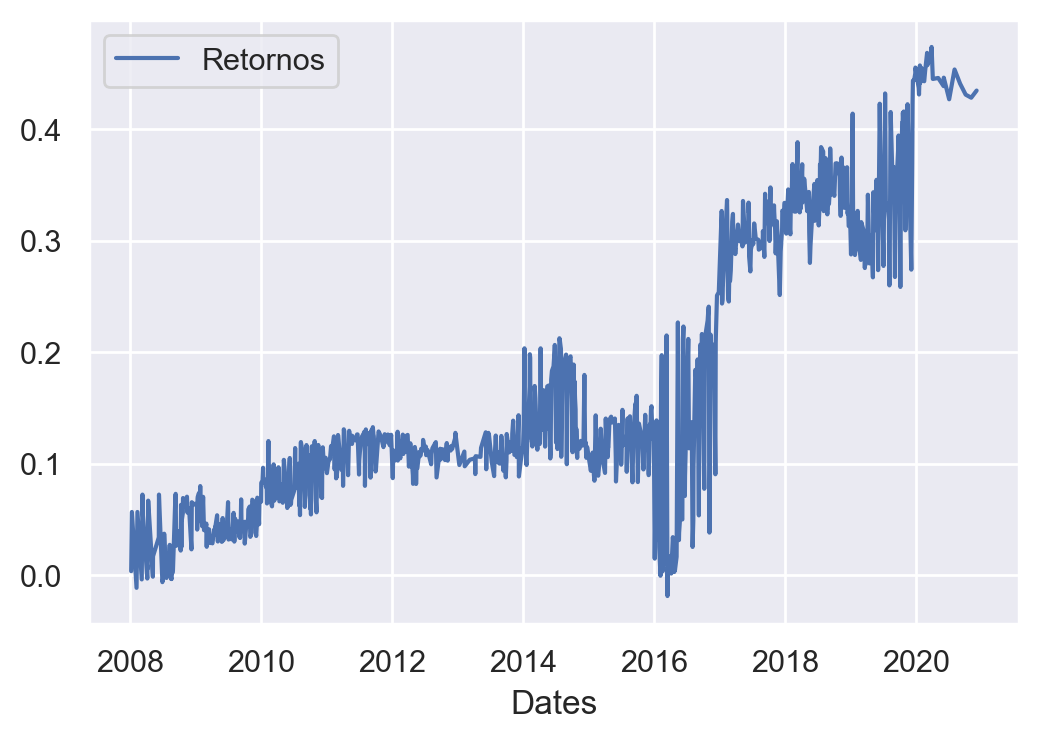

In [115]:
sns.lineplot(data = np.exp(ret.cumsum())-1)

In [ ]:
# Em construção
print(knn_KF[2])
recall = TP / (TP + FN) # true positive rate
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
print(recall)
print(accuracy)
print(precision)

### Códigos para Testar o kNN

In [98]:
s_KF_norm = (s_KF - np.mean(s_KF))/np.std(s_KF, ddof=1)
r = retornos_pares(s_KF_norm, adf_KF, janela_coint)
r = 1*(r>=np.median(r))
yX = pd.concat([r,np.abs(s_KF_norm).shift(-1),np.abs(s_KF_norm).shift(-2)],axis=1,sort=True).dropna()

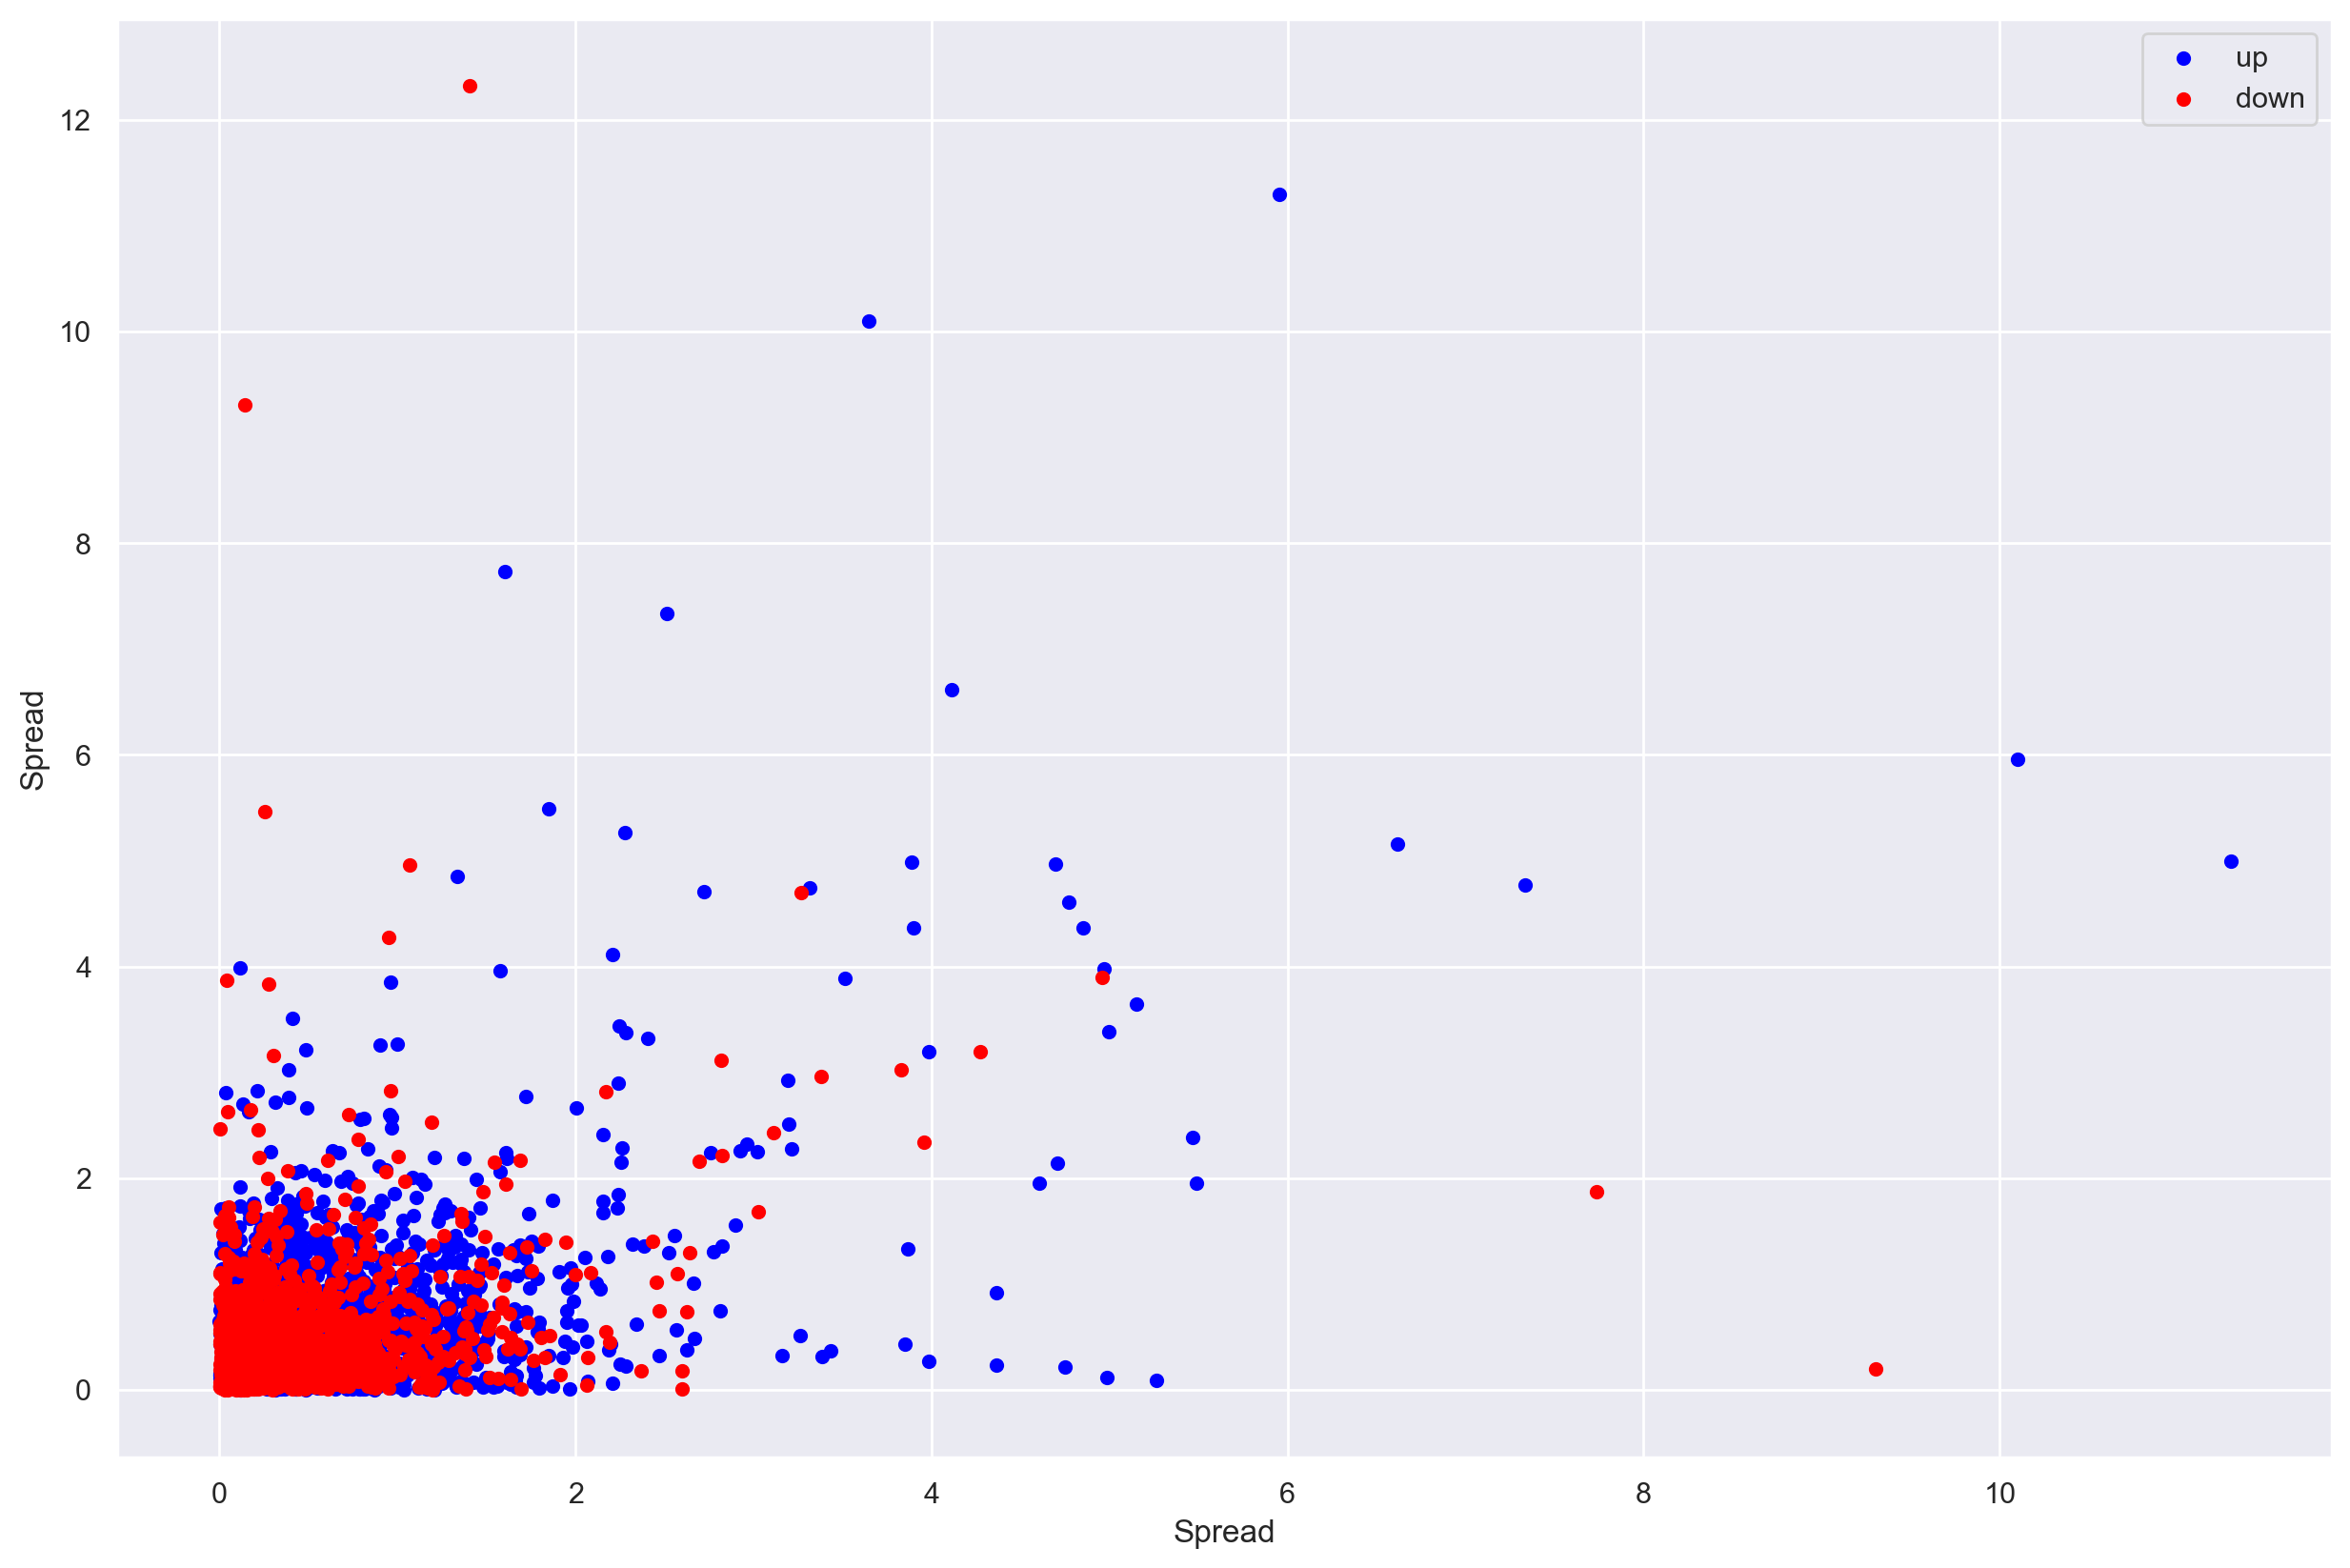

In [99]:
plt.figure(figsize=(15,10))
plot_df = yX[yX.iloc[:,0] == 1]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'blue', label = 'up')
plot_df = yX[yX.iloc[:,0] == 0]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'red', label = 'down')
plt.legend()
plt.xlabel(plot_df.columns[1])
plt.ylabel(plot_df.columns[2])
plt.show()